# Artigo 8 - Sonic or Eggman

## Objetivo

Para esse artigo, o objetivo é colocar em prática os conhecimentos da última lição do curso do fastai, a lição 08, que trata de CNNs, disponível em [8: Convolutions (CNNs)](https://course.fast.ai/Lessons/lesson8.html) (Parte do meio para o final). Nesse caso o objetivo é explorar as redes Convolucionais, que são redes utilizadas em tarefas de visão computacional, e nesse caso específico, será trabalhado a classificação de imagens, onde se pretende classificar entre o Sonic e o Doutor Eggman que são personagens do desenho do Sonic. No final, o resultado será exportado em forma de um modelo disponibilizado no Hugging Face.

## Motivação

É preciso saber de quem se está falando, pois o Doutor Eggman é um vilão, enquanto o Sonic é o herói, e saber exatamente de quem se está falando pode salvar a vida de alguém.

## Requisitos
Para se realizar essa tarefa é necessário ter algumas bibliotecas que servirão para poder fazer toda a manipulação dos dados e até mesmo para a criação do modelo, todas elas podem ser encontradas nas células 01 e 02.

In [1]:
#Instalando
!pip install -Uqq fastai
!pip install -Uqq duckduckgo_search

In [2]:
#Importando
from fastcore.all import *
from fastai.vision.all import *
from fastdownload import download_url
from duckduckgo_search import ddg_images
from time import sleep
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Dados

Um primeiro passo, para facilitar o trabalho, é criar uma função que seja capaz de procurar pelas imagens desejadas, essa função pode ser visualizada na célula 03.

In [3]:
def search_imagens(term, max_images=300): return L(ddg_images(term, max_results=max_images)).itemgot('image')

De posse da função a primeira coisa é baixar imagens de exemplos para que se possa avaliar e entender que tipo de imagens irão aparecer quando se for buscar em abundância, esse processo é apresentado nas células 04 e 05.

/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


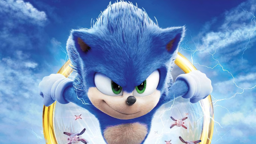

In [4]:
sonic = search_imagens('Sonic the Hedgehog', max_images=1)[0]
download_url(sonic, 'sonic.jpg', show_progress=False)

Image.open('sonic.jpg').to_thumb(256, 256)

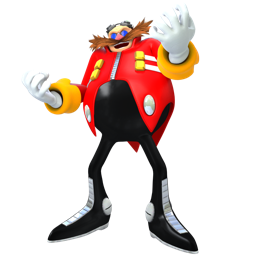

In [5]:
eggman = search_imagens('Doutor Eggman', max_images=1)[0]
download_url(eggman, 'eggman.jpg', show_progress=False)

Image.open('eggman.jpg').to_thumb(256, 256)

Se observa que as imagens são satisfatórias, tendo isso em vista, pode-se baixar várias de cada uma delas, que serão usadas pelo modelo a ser treinado. Esse processo pode ser observado na célula 06 onde serão baixadas e na célula 07 onde serão retiradas aquelas que tiveram algum erro.

In [6]:
searchs = 'Sonic the Hedgehog', 'Doutor Eggman'
path = Path('characters')

for characters in searchs:
    dest = (path/characters)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_imagens(f'{characters}'))
    sleep(5)
    resize_images(path/characters, max_size=400, dest=path/characters)

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

Com isso se observa que não teve falhas ao baixar as imagens, e isso é ótimo.

O próximo passo é criar o conjunto de dados que serão apresentados para o modelo quando ele for treinado, esse processo pode ser observado na célula 08.

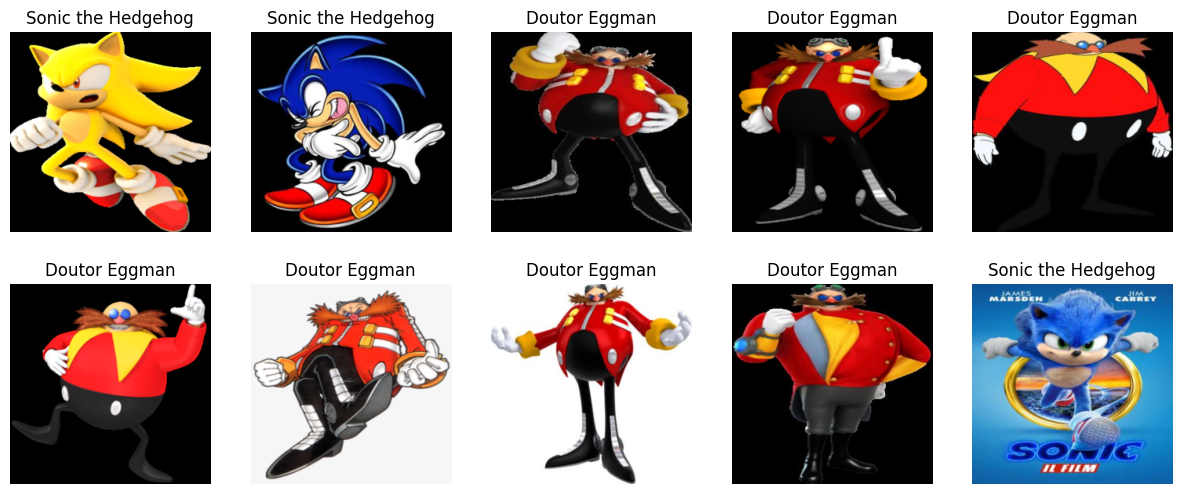

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(256, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=10, nrows=2)

Com isso se tem os dados necessários para se trabalhar e criar o modelo, porém antes disso, é importante entender o que é a Convolução.

## Convolução

O ato de convolucionar se trata de pegar uma imagem e trabalhar sobre ela, utilizando sua visualização como matriz, no caso, quando se convoluçona uma imagem, pode-se dizer que está sendo aplicado um filtro sobre ele, o que muda seu aspecto, podendo ter vários objetivos com isso, como destacar linhas horizontais e verticais. E essa operação é feita a partir da aplicação de uma matriz que irá representar o filtro conhecido também como Kenel sobre toda a imagem, fazendo o produto escalar, variando a posição na imagem onde essa matriz é aplicada, para que se possa aplicar em toda a imagem original, resultado em uma nova imagem com o filtro aplicado.

Para exemplificar, serão feitos alguns filtros manuais e demonstrado seus efeitos sobre uma imagem.

Primeiro é necessário escolher uma imagem, redimensionar ela para ter uma quantidade menor de píxeis para ser mais fácil de se trabalhar sobre ela e para poder se enxergar melhor o resultado, esse processo pode ser observado na célula 09.

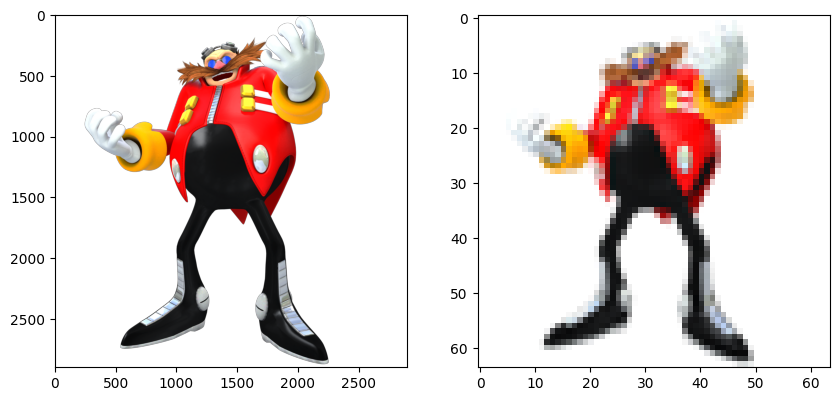

In [9]:
eggman_b = Image.open('eggman.jpg') #Eggman base
eggman_r = eggman_b.resize((64 ,64)) #Eggman redimensionado

eggman_a = np.asarray(eggman_r) #Eggman em forma de array
eggman_i = np.asarray(eggman_b, dtype=np.uint8) #Eggman inicial

fig, axs = plt.subplots(1, 2, figsize=(10,5))

axs[0].imshow(eggman_i)
axs[1].imshow(eggman_a)

Com isso pode se começar a trabalhar em alguns exemplos manuais antes que se use a biblioteca fastai para poder criar um modelo.

### Nitidez

Para esse exemplo o objetivo é aplicar um filtro de Nitidez na imagem a fim de se realçar os detalhes da mesma, a criação desse filtro manualmente pode ser observada na célula 10.

Sendo que como são imagens RGB, precisa ser um filtro 3x3x3.

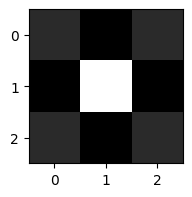

In [10]:
nitidez = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
fig, ax = plt.subplots(1, 1, figsize=(2,2))
ax.imshow(nitidez, cmap='gray')
plt.show()

Agora com o filtro pronto pode se aplicar ele a imagem e se observar seu resultado, esse processo pode ser observado na célula 11

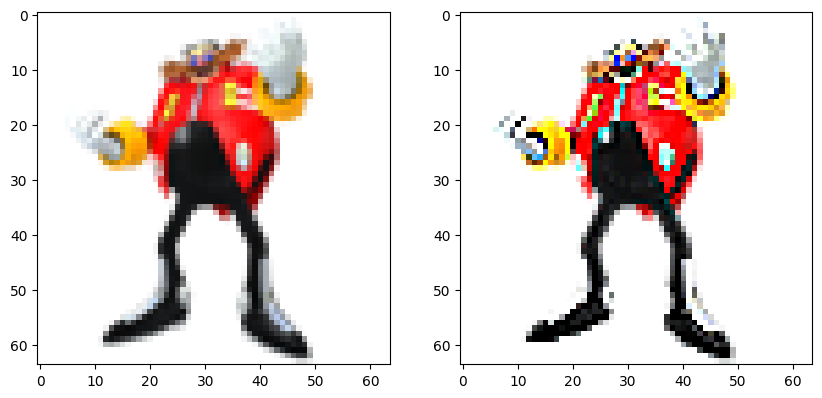

In [11]:
eggman_c = eggman_a.copy()
height, width, _ = eggman_c.shape

for color in range(3):
    for i in range(1, height-1):
        for j in range(1, width-1):
            sum = 0
            for ki in range(-1, 2):
                for kj in range(-1, 2):
                    sum += eggman_a[i+ki, j+kj, color] * nitidez[ki+1][kj+1]
            eggman_c[i, j, color] = min(max(int(sum), 0), 255)

fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(eggman_a)
axs[1].imshow(eggman_c)

## Modelo

Agora que já se tem em mente o que é a Convolução, pode se passar para a criação do modelo, nesse caso, como se deseja uma rede neural que use a convolução se tem que escolher uma família que se utilize dessa técnica, nesse caso, foi escolhido a família resnet, que usa essa técnica, o processo de treinamento desse modelo pode ser observado na célula 12.

In [12]:
learn = vision_learner(dls, resnet34, metrics=[error_rate, accuracy])
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.765080,0.018636,0.000000,1.000000,00:04


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.127308,0.021715,0.000000,1.000000,00:03
1,0.073596,0.004769,0.000000,1.000000,00:02
2,0.046977,0.003003,0.000000,1.000000,00:02
3,0.032833,0.002087,0.000000,1.000000,00:02
4,0.024780,0.001952,0.000000,1.000000,00:02


É possível notar que o modelo se saiu bem, então para confirmar será feito um teste com as primeiras imagens baixadas no começo para ver o que ele retorna, esse processo pode ser observadi nas células 13 e 14.

In [13]:
# Sonic
is_sonic,_,probs = learn.predict(PILImage.create('sonic.jpg'))
print(f"{is_sonic}.")
print(f"Probabilidade: {probs[1]:.4f}")

Sonic the Hedgehog.
Probabilidade: 1.0000


In [14]:
# Eggman
is_eggman,_,probs = learn.predict(PILImage.create('eggman.jpg'))
print(f"{is_eggman}.")
print(f"Probabilidade: {probs[0]:.4f}")

Doutor Eggman.
Probabilidade: 1.0000


Se observa que realmente o modelo está correto e suas previsões.

## Exportando

Para finalizar a célula 15 mostra a exportação do modelo e ele pode ser observado em: [Sonic](https://huggingface.co/spaces/fastaioncampus/Sonic).

In [15]:
learn.export('model.pkl')